In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
plt.style.use("seaborn-v0_8")
pd.set_option("display.max_columns", 100)

## Step 1: Load Observation Data + Target

In [3]:
obs_df = pd.read_csv("../data/processed/online_retail_II_clean.csv")
customer_clv = pd.read_parquet("../data/processed/customer_clv_6m.parquet")

In [4]:
obs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397885 entries, 0 to 397884
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   invoice       397885 non-null  int64  
 1   stock_code    397885 non-null  object 
 2   description   397885 non-null  object 
 3   quantity      397885 non-null  int64  
 4   invoice_date  397885 non-null  object 
 5   price         397885 non-null  float64
 6   customer_id   397885 non-null  float64
 7   country       397885 non-null  object 
 8   is_cancelled  397885 non-null  bool   
 9   revenue       397885 non-null  float64
dtypes: bool(1), float64(3), int64(2), object(4)
memory usage: 27.7+ MB


In [5]:
obs_df["invoice_date"] = pd.to_datetime(obs_df["invoice_date"])

In [6]:
cutoff_date = pd.Timestamp("2011-06-01")

In [8]:
obs_df = obs_df.loc[obs_df["invoice_date"] < cutoff_date].copy()

In [9]:
# define customer “Snapshot Date”
snapshot_date = cutoff_date

## Step 2: Core RFM Features

**Recency (days since last purchase)**

In [10]:
recency = (
    obs_df.groupby("customer_id")
    .agg(last_purchase=("invoice_date", "max"))
    .reset_index()
)

In [11]:
recency["recency_days"] = (snapshot_date - recency["last_purchase"]).dt.days

**Frequency (number of unique invoices)**

In [12]:
frequency = (
    obs_df.groupby("customer_id").agg(frequency=("invoice", "nunique")).reset_index()
)

**Monetary Value (total & average spend)**

In [13]:
monetary = (
    obs_df.groupby("customer_id")
    .agg(total_revenue=("revenue", "sum"), avg_order_value=("revenue", "mean"))
    .reset_index()
)

## Step 3: Customer Tenure

In [14]:
tenure = (
    obs_df.groupby("customer_id")
    .agg(first_purchase=("invoice_date", "min"))
    .reset_index()
)

In [15]:
tenure["tenure_days"] = (snapshot_date - tenure["first_purchase"]).dt.days

## Step 4: Purchase Velocity & Intensity

**Active months**

In [17]:
obs_df["year_month"] = obs_df["invoice_date"].dt.to_period("M")

In [18]:
active_months = (
    obs_df.groupby("customer_id")
    .agg(active_months=("year_month", "nunique"))
    .reset_index()
)

**Purchase velocity (transactions per active month)**

In [19]:
velocity = frequency.merge(active_months, on="customer_id")

In [20]:
velocity["purchase_velocity"] = velocity["frequency"] / velocity["active_months"]

## Step 5: Inter-Purchase Time (Behavioral Stability)

In [22]:
obs_df = obs_df.sort_values(["customer_id", "invoice_date"])

In [23]:
obs_df["prev_purchase"] = obs_df.groupby("customer_id")["invoice_date"].shift(1)

In [25]:
obs_df["gap_days"] = (obs_df["invoice_date"] - obs_df["prev_purchase"]).dt.days

In [28]:
# aggregate gaps
purchase_gaps = (
    obs_df.groupby("customer_id")
    .agg(avg_gap_days=("gap_days", "mean"), std_gap_days=("gap_days", "std"))
    .reset_index()
)

In [29]:
# fill NaNs (customers with 1 purchase)
purchase_gaps["avg_gap_days"] = purchase_gaps["avg_gap_days"].fillna(999)
purchase_gaps["std_gap_days"] = purchase_gaps["std_gap_days"].fillna(0)

## Step 6: Assemble Feature Table

In [30]:
features = (
    recency.merge(frequency, on="customer_id")
    .merge(monetary, on="customer_id")
    .merge(tenure, on="customer_id")
    .merge(active_months, on="customer_id")
    .merge(velocity[["customer_id", "purchase_velocity"]], on="customer_id")
    .merge(purchase_gaps, on="customer_id")
)

In [31]:
# join target
dataset = features.merge(customer_clv, on="customer_id", how="inner")

In [33]:
dataset.head()

,customer_id,last_purchase,recency_days,frequency,total_revenue,avg_order_value,first_purchase,tenure_days,active_months,purchase_velocity,avg_gap_days,std_gap_days,clv_6m
0,12346.0,2011-01-18 10:01:00,133,1,77183.60,77183.600000,2011-01-18 10:01:00,133,1,1.0,999.000000,0.000000,0.00
1,12347.0,2011-04-07 10:43:00,54,3,1823.43,21.707500,2010-12-07 14:57:00,175,3,1.0,1.433735,9.325016,2261.75
2,12348.0,2011-04-05 10:47:00,56,3,1487.24,53.115714,2010-12-16 19:09:00,166,3,1.0,4.037037,15.166972,310.00
3,12350.0,2011-02-02 16:01:00,118,1,334.40,19.670588,2011-02-02 16:01:00,118,1,1.0,0.000000,0.000000,0.00
4,12352.0,2011-03-22 16:08:00,70,5,1561.81,41.100263,2011-02-16 12:33:00,104,2,2.5,0.918919,3.410591,944.23


## Step 7: Final Sanity Checks

In [34]:
dataset.isna().mean()

customer_id          0.0
last_purchase        0.0
recency_days         0.0
frequency            0.0
total_revenue        0.0
avg_order_value      0.0
first_purchase       0.0
tenure_days          0.0
active_months        0.0
purchase_velocity    0.0
avg_gap_days         0.0
std_gap_days         0.0
clv_6m               0.0
dtype: float64

In [35]:
dataset.describe()

,customer_id,last_purchase,recency_days,frequency,total_revenue,avg_order_value,first_purchase,tenure_days,active_months,purchase_velocity,avg_gap_days,std_gap_days,clv_6m
count,2718.000000,2718,2718.000000,2718.000000,2718.000000,2718.000000,2718,2718.000000,2718.000000,2718.000000,2718.000000,2718.000000,2718.000000
mean,15293.879323,2011-03-29 13:34:57.549668864,62.974614,2.725901,1226.119191,66.203794,2011-02-09 02:41:29.028697600,111.428256,1.938926,1.238576,27.925430,5.214698,1436.314552
min,12346.000000,2010-12-01 09:53:00,0.000000,1.000000,2.900000,1.450000,2010-12-01 08:26:00,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,13819.500000,2011-02-24 12:30:30,19.000000,1.000000,242.717500,12.852159,2010-12-14 09:57:00,68.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,15242.500000,2011-04-12 10:31:30,49.000000,2.000000,476.115000,18.011774,2011-02-03 10:01:30,117.000000,1.000000,1.000000,0.188470,0.000000,397.880000
75%,16767.750000,2011-05-12 13:36:00,96.000000,3.000000,1070.040000,26.582866,2011-03-24 12:42:30,168.000000,2.000000,1.200000,1.727033,8.419479,1220.677500
max,18287.000000,2011-05-31 15:41:00,181.000000,86.000000,110713.120000,77183.600000,2011-05-31 15:32:00,181.000000,6.000000,34.000000,999.000000,70.003571,183529.650000
std,1715.705215,NaN,52.394210,4.025443,4122.445975,1486.517799,NaN,54.760426,1.324976,0.885872,160.282760,7.895064,6688.806620


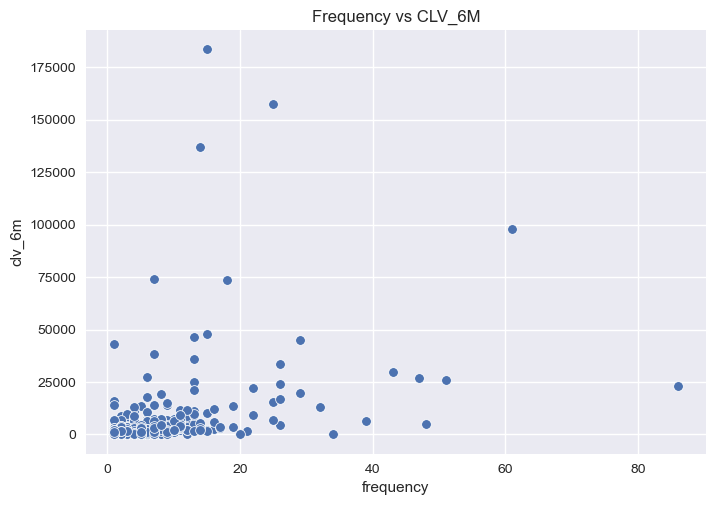

In [36]:
# target vs features
sns.scatterplot(x="frequency", y="clv_6m", data=dataset)
plt.title("Frequency vs CLV_6M")
plt.show()

## Step 8: Save Final Dataset

In [37]:
dataset.to_parquet("../data/processed/clv_modeling_table.parquet", index=False)